In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras_tuner

import lightgbm as lgb

from matplotlib.pyplot import figure

import os

from scikeras.wrappers import KerasClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.utils import to_categorical

import xgboost as xgb

In [2]:
def zscore_normalization(df, col_name):
    mean = df[col_name].mean()
    std = df[col_name].std()
    df[col_name] = (df[col_name] - mean) / std

    return df

In [3]:
ddos_files = []
DATA_PATH = os.path.join(os.getcwd(), 'kaggle_data')

for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        if filename.endswith('.parquet'):
            data_fp = os.path.join(dirname, filename)
            ddos_files.append(data_fp)
            print(data_fp)

# remove portmap data
ddos_files.remove(os.path.join(DATA_PATH, 'Portmap-training.parquet'))

ddos_df = pd.concat([pd.read_parquet(dfp) for dfp in ddos_files], ignore_index=True)

ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: -1000 if x <= -10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: -1000 if x <= -10000 else x)

ddos_df['Fwd Header Length'] = ddos_df['Fwd Header Length'].apply(lambda x: 1000 if x >= 10000 else x)
ddos_df['Fwd Seg Size Min'] = ddos_df['Fwd Seg Size Min'].apply(lambda x: 1000 if x >= 10000 else x)

ddos_df['Label'] = ddos_df['Label'].replace('UDP-lag', 'UDPLag') # rename since they are the same thing

drop_cols = {
    'Bwd PSH Flags',
    'Fwd URG Flags',
    'Bwd URG Flags',
    'FIN Flag Count',
    'PSH Flag Count',
    'ECE Flag Count',
    'Fwd Avg Bytes/Bulk',
    'Fwd Avg Packets/Bulk',
    'Fwd Avg Bulk Rate',
    'Bwd Avg Bytes/Bulk',
    'Bwd Avg Packets/Bulk',
    'Bwd Avg Bulk Rate'
}

for col in drop_cols:
    ddos_df.drop(col, axis=1, inplace=True)

cols = ddos_df.columns
cols = cols.drop('Label')
cols = cols.drop('Protocol') # Don't normalize the protocol value
for col in cols:
    ddos_df = zscore_normalization(ddos_df, col)

# Encode labels and separate features and target
label_encoder = LabelEncoder()
label_encoder.fit(ddos_df['Label'].unique())

ddos_df['Label'] = label_encoder.transform(ddos_df['Label'])

label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for label, encoded_value in label_mapping.items():
    print(f"Label: {label} - Encoded Value: {encoded_value}")

g:\UVM\CS3540\_fp\kaggle_data\DNS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\LDAP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\MSSQL-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\NetBIOS-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\NTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Portmap-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\SNMP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\Syn-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\TFTP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDP-training.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-testing.parquet
g:\UVM\CS3540\_fp\kaggle_data\UDPLag-training.parquet
Label: Benign - Encoded Value: 0
Label: DrDoS_DNS - Encoded Value: 1
Label: DrDoS_LDAP - Encoded Value: 2
Label: DrDo

In [4]:
ddos_X = ddos_df.drop(columns=['Label'])
ddos_y = to_categorical(ddos_df['Label'])

X_split, X_val, y_split, y_val = train_test_split(ddos_X, ddos_y, test_size=0.6, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_split, y_split, test_size=0.2, random_state=87)

In [5]:
X_train.shape[1]

65

In [6]:
# Step 3: Define the Feedforward Neural Network (FNN) Model
model = models.Sequential()

# Input layer (based on the number of features)
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

# Hidden Layer 1 (128 units with ReLU activation)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Hidden Layer 2 (64 units with ReLU activation)
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output Layer (softmax activation for multi-class classification)
model.add(layers.Dense(y_train.shape[1], activation='softmax'))  # Number of classes

# Step 4: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,744 (69.31 KB)

 Trainable params: 17,744 (69.31 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Step 6: Evaluate the model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

Epoch 1/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7367 - loss: 0.9408 - val_accuracy: 0.9099 - val_loss: 0.3734
Epoch 2/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8980 - loss: 0.3417 - val_accuracy: 0.9099 - val_loss: 0.2790
Epoch 3/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9054 - loss: 0.2802 - val_accuracy: 0.9146 - val_loss: 0.2410
Epoch 4/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9087 - loss: 0.2537 - val_accuracy: 0.9170 - val_loss: 0.2211
Epoch 5/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9090 - loss: 0.2395 - val_accuracy: 0.9178 - val_loss: 0.2284
Epoch 6/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9103 - loss: 0.2376 - val_accuracy: 0.9194 - val_loss: 0.2318
Epoch 7/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9108 - loss: 0.2388 - val_accuracy: 0.9223 - val_loss: 0.2186
Epoch 8/10
2132/2132 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9113 - loss: 0.2312 - 

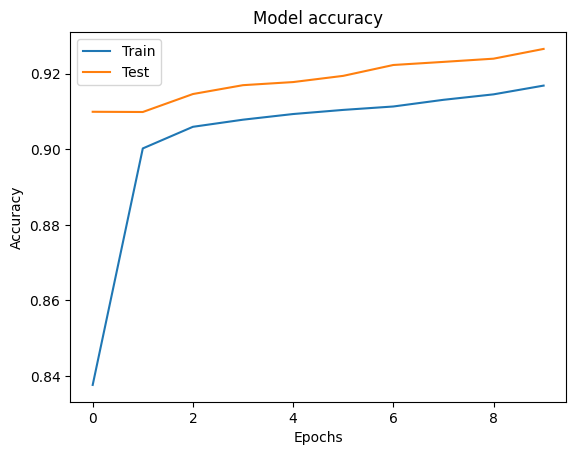

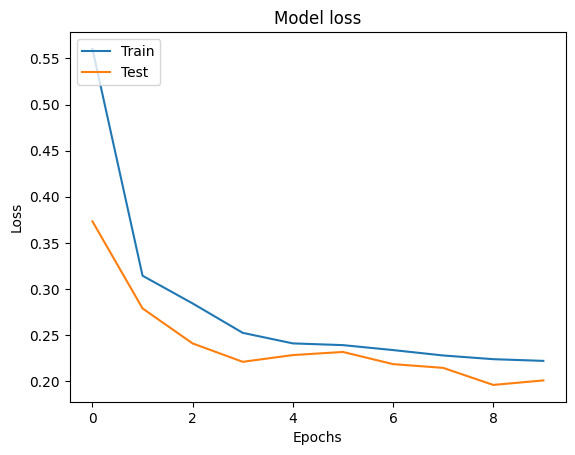

In [8]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 1s 514us/step


g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      7609
           1       0.38      0.45      0.41       297
           2       0.00      0.00      0.00       125
           3       0.40      0.00      0.01       471
           4       1.00      0.99      0.99      9805
           5       0.00      0.00      0.00        55
           6       0.46      0.76      0.57       234
           7       0.00      0.00      0.00       806
           8       0.00      0.00      0.00       141
           9       0.48      0.89      0.62       642
          10       0.41      0.96      0.58        50
          11       0.97      0.96      0.97      3880
          12       1.00      0.99      1.00      7824
          13       0.58      0.97      0.73      1438
          14       0.76      0.64      0.69       719
          15       0.00      0.00      0.00         6

    accuracy                           0.93     34102
   

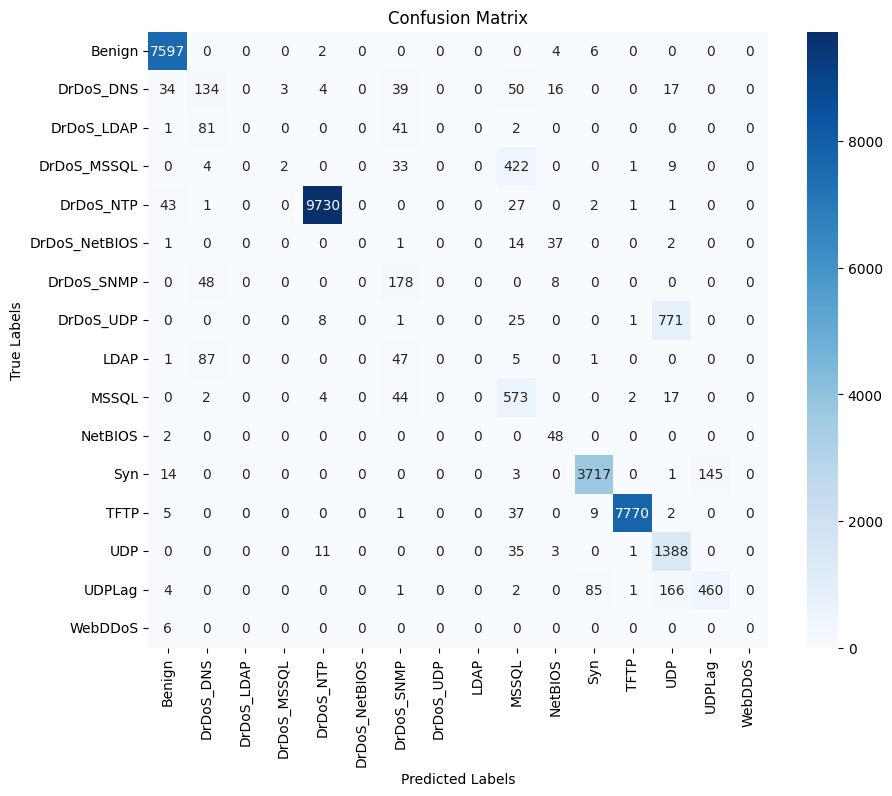

In [9]:
y_pred = model.predict(X_test)

# If y_pred is one-hot encoded, convert it to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# If y_test is one-hot encoded, convert it to class labels as well
y_test_labels = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

# Add labels and title
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Keras-Tuner Hyperparameter Search

In [10]:
def create_model(hp):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))
    
    # Hyperparameter for number of hidden layers
    num_layers = hp.Int('num_layers', min_value=2, max_value=6, step=1)
    
    # Add hidden layers with units and dropout
    for i in range(num_layers):
        num_units = hp.Int(f'num_units_{i}', min_value=32, max_value=256, step=32)
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.2, max_value=0.5, step=0.1)
        model.add(layers.Dense(num_units, activation='relu'))
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))  # Multi-class classification
    
    # Hyperparameter for learning rate
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='log')
    
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weight_dict = dict(zip(np.unique(np.argmax(y_train, axis=1)), class_weights))

In [16]:
tuner = keras_tuner.Hyperband(
    create_model,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_epochs=15,
    factor=3,
    hyperband_iterations=5,
    directory='keras_tuner',
    project_name='cicddos_tuning'
)

Reloading Tuner from keras_tuner\cicddos_tuning\tuner0.json


In [17]:
tuner.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test), class_weight=class_weight_dict)

Trial 60 Complete [00h 00m 55s]
val_accuracy: 0.8767814040184021

Best val_accuracy So Far: 0.8990968465805054
Total elapsed time: 00h 27m 15s


In [18]:
best_model = tuner.get_best_models(1)[0]
best_model.summary()

# Step 7: Evaluate the best model
test_loss, test_acc = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,248 (184.56 KB)

 Trainable params: 47,248 (184.56 KB)

 Non-trainable params: 0 (0.00 B)

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.9003 - loss: 0.3193
Test Accuracy: 0.8990968465805054


1066/1066 ━━━━━━━━━━━━━━━━━━━━ 1s 562us/step


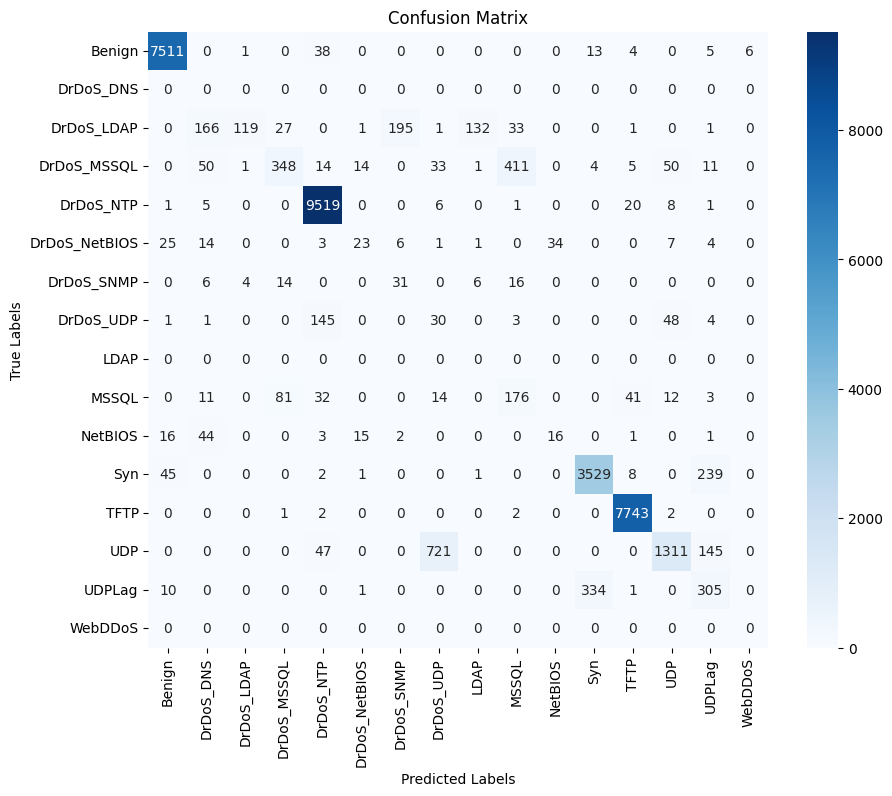

In [20]:
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_pred_labels, y_test_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [30]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_labels, y_pred_labels, average=None)

# Print precision, recall, and F1-score for each class
print("\nPrecision, Recall, and F1-Score per class:")
for i in range(len(precision)):
    print(f"Class {i}: Precision = {precision[i]:.4f}, Recall = {recall[i]:.4f}, F1-Score = {f1[i]:.4f}")

# Step 11: Calculate Weighted Average Precision, Recall, and F1-Score
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(y_test_labels, y_pred_labels, average='weighted')

print("\nWeighted Average Precision, Recall, and F1-Score:")
print(f"Weighted Precision = {precision_weighted:.4f}")
print(f"Weighted Recall = {recall_weighted:.4f}")
print(f"Weighted F1-Score = {f1_weighted:.4f}")

report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(report)


Precision, Recall, and F1-Score per class:
Class 0: Precision = 0.9912, Recall = 0.9871, F1-Score = 0.9891
Class 1: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000
Class 2: Precision = 0.1760, Recall = 0.9520, F1-Score = 0.2971
Class 3: Precision = 0.3694, Recall = 0.7389, F1-Score = 0.4926
Class 4: Precision = 0.9956, Recall = 0.9708, F1-Score = 0.9831
Class 5: Precision = 0.1949, Recall = 0.4182, F1-Score = 0.2659
Class 6: Precision = 0.4026, Recall = 0.1325, F1-Score = 0.1994
Class 7: Precision = 0.1293, Recall = 0.0372, F1-Score = 0.0578
Class 8: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000
Class 9: Precision = 0.4757, Recall = 0.2741, F1-Score = 0.3478
Class 10: Precision = 0.1633, Recall = 0.3200, F1-Score = 0.2162
Class 11: Precision = 0.9226, Recall = 0.9095, F1-Score = 0.9160
Class 12: Precision = 0.9991, Recall = 0.9896, F1-Score = 0.9943
Class 13: Precision = 0.5895, Recall = 0.9117, F1-Score = 0.7160
Class 14: Precision = 0.4685, Recall = 0.4242, F1-Score 

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Without Weighted Class

In [ ]:
tuner_2 = keras_tuner.Hyperband(
    create_model,
    objective='val_accuracy',  # We aim to optimize validation accuracy
    max_epochs=15,
    factor=3,
    hyperband_iterations=5,
    directory='keras_tuner',
    project_name='cicddos_tuning_2'
)

tuner_2.search(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Trial 81 Complete [00h 00m 25s]
val_accuracy: 0.9197114706039429

Best val_accuracy So Far: 0.9358981847763062
Total elapsed time: 00h 40m 28s

Search: Running Trial #82

Value             |Best Value So Far |Hyperparameter
5                 |2                 |num_layers
192               |160               |num_units_0
0.2               |0.2               |dropout_rate_0
192               |192               |num_units_1
0.4               |0.3               |dropout_rate_1
0.00036966        |0.00028517        |learning_rate
96                |192               |num_units_2
0.2               |0.2               |dropout_rate_2
96                |224               |num_units_3
0.2               |0.3               |dropout_rate_3
192               |160               |num_units_4
0.4               |0.3               |dropout_rate_4
32                |192               |num_units_5
0.3               |0.2               |dropout_rate_5
5                 |15                |tuner/epochs
0     

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


4263/4263 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.7907 - loss: 0.6577 - val_accuracy: 0.9099 - val_loss: 0.2373
Epoch 2/5
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9062 - loss: 0.2544 - val_accuracy: 0.9175 - val_loss: 0.2084
Epoch 3/5
4263/4263 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9111 - loss: 0.2304 - val_accuracy: 0.9187 - val_loss: 0.2015
Epoch 4/5
3328/4263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9141 - loss: 0.2173

In [12]:
best_model_2 = tuner_2.get_best_models(1)[0]
best_model_2.summary()

# Step 7: Evaluate the best model
test_loss, test_acc = best_model_2.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')

g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
g:\UVM\CS3540\_fp\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         8,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160)            │         5,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         2,576 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,248 (184.56 KB)

 Trainable params: 47,248 (184.56 KB)

 Non-trainable params: 0 (0.00 B)

1066/1066 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step - accuracy: 0.9003 - loss: 0.3193
Test Accuracy: 0.8990968465805054


1066/1066 ━━━━━━━━━━━━━━━━━━━━ 1s 568us/step


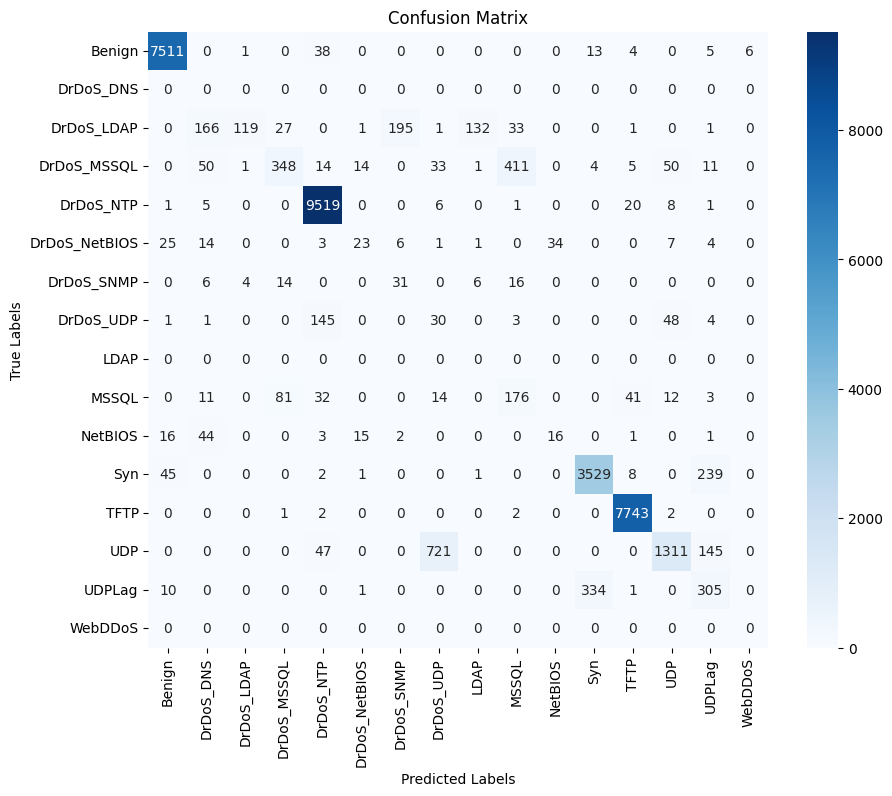

In [23]:
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_pred_labels, y_test_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
report = classification_report(y_test_labels, y_pred_labels)
print("Classification Report:")
print(report)